# Import Libraries

In [1]:
# Installing spark and pip packages
!pip install wget
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
!tar xf spark-3.3.1-bin-hadoop3.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=2392e2db0292ef04db8d92ad3bb0c36881e0b2a8529fcebc34a59bbfd5da01d7
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [2]:
# Importing spark session
import findspark
findspark.init()
from pyspark.sql import SparkSession 
from pyspark.sql import SQLContext 

# Import other libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import warnings
warnings.filterwarnings('ignore')

# Load data

## Read Data

In [3]:
spark = SparkSession.builder.appName('deposit').getOrCreate()

url = "https://raw.githubusercontent.com/saswatarautray/pyspark-deposit-opening-classification/main/XYZ_Bank_Deposit_Data_Classification.csv"
from pyspark import SparkFiles
spark.sparkContext.addFile(url)

df = spark.read.csv("file://"+SparkFiles.get("XYZ_Bank_Deposit_Data_Classification.csv"), sep =';', inferSchema="true", header="true")
# Replacing . with _ in the column names
new_cols=(column.replace('.', '_') for column in df.columns)
df = df.toDF(*new_cols)
df.show(5)

+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|      job|marital|  education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 56|housemaid|married|   basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 57| services|married|high.school|unknown|     no|  no|telephone|  may|        mon|     149|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 37| serv

In [4]:
# Data distribution
df.printSchema() 

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)



## Check for Null values

In [5]:
# Check the null column count

from pyspark.sql.functions import col,isnan, when, count
df.select([count(when(isnan(a) | col(a).isNull(), a)).alias(a) for a in df.columns]).show()

+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+
|age|job|marital|education|default|housing|loan|contact|month|day_of_week|duration|campaign|pdays|previous|poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+
|  0|  0|      0|        0|      0|      0|   0|      0|    0|          0|       0|       0|    0|       0|       0|           0|             0|            0|        0|          0|  0|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+



In [6]:
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).toPandas().head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Missing Attribute Values: There are several values in some categorical attributes coded with the "unknown" label. These missing values can be treated as a possible class label or using deletion or imputation techniques. We are treating them as possible class label.

# EDA

In [7]:
sqlContext = SQLContext(spark)

# Registering df as sql table named "bank" for eda
df.registerTempTable("bank") 

### Facts

In [8]:
# Summarize
df.describe([t[0] for t in df.dtypes if t[1] != 'string']).show()

+-------+------------------+-----------------+-----------------+------------------+-------------------+-------------------+------------------+-------------------+------------------+-----------------+
|summary|               age|         duration|         campaign|             pdays|           previous|       emp_var_rate|    cons_price_idx|      cons_conf_idx|         euribor3m|      nr_employed|
+-------+------------------+-----------------+-----------------+------------------+-------------------+-------------------+------------------+-------------------+------------------+-----------------+
|  count|             41188|            41188|            41188|             41188|              41188|              41188|             41188|              41188|             41188|            41188|
|   mean| 40.02406040594348|258.2850101971448|2.567592502670681| 962.4754540157328|0.17296299893172767|0.08188550063188142|   93.575664368313|-40.502600271913245| 3.621290812858178|5167.035910942858|


### Univariate patterns

+---+-----+
|  y|count|
+---+-----+
| no|36548|
|yes| 4640|
+---+-----+



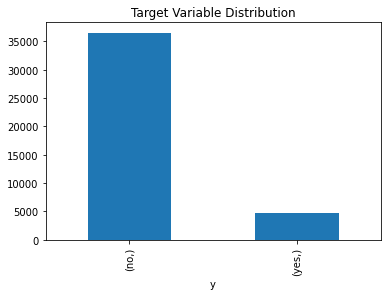

In [9]:
# Target Variable Distribution
 
df.groupby("y").count().show()
sqlContext.sql("SELECT y from bank").toPandas().value_counts().plot(kind='bar', title="Target Variable Distribution")  # Class Imbalance; Yes=12.7%

The deposit subscription rate is only 12.7%. Hence the Y variable has a high class imbalance. Hence accuracy will not be a reliable model performance measure.

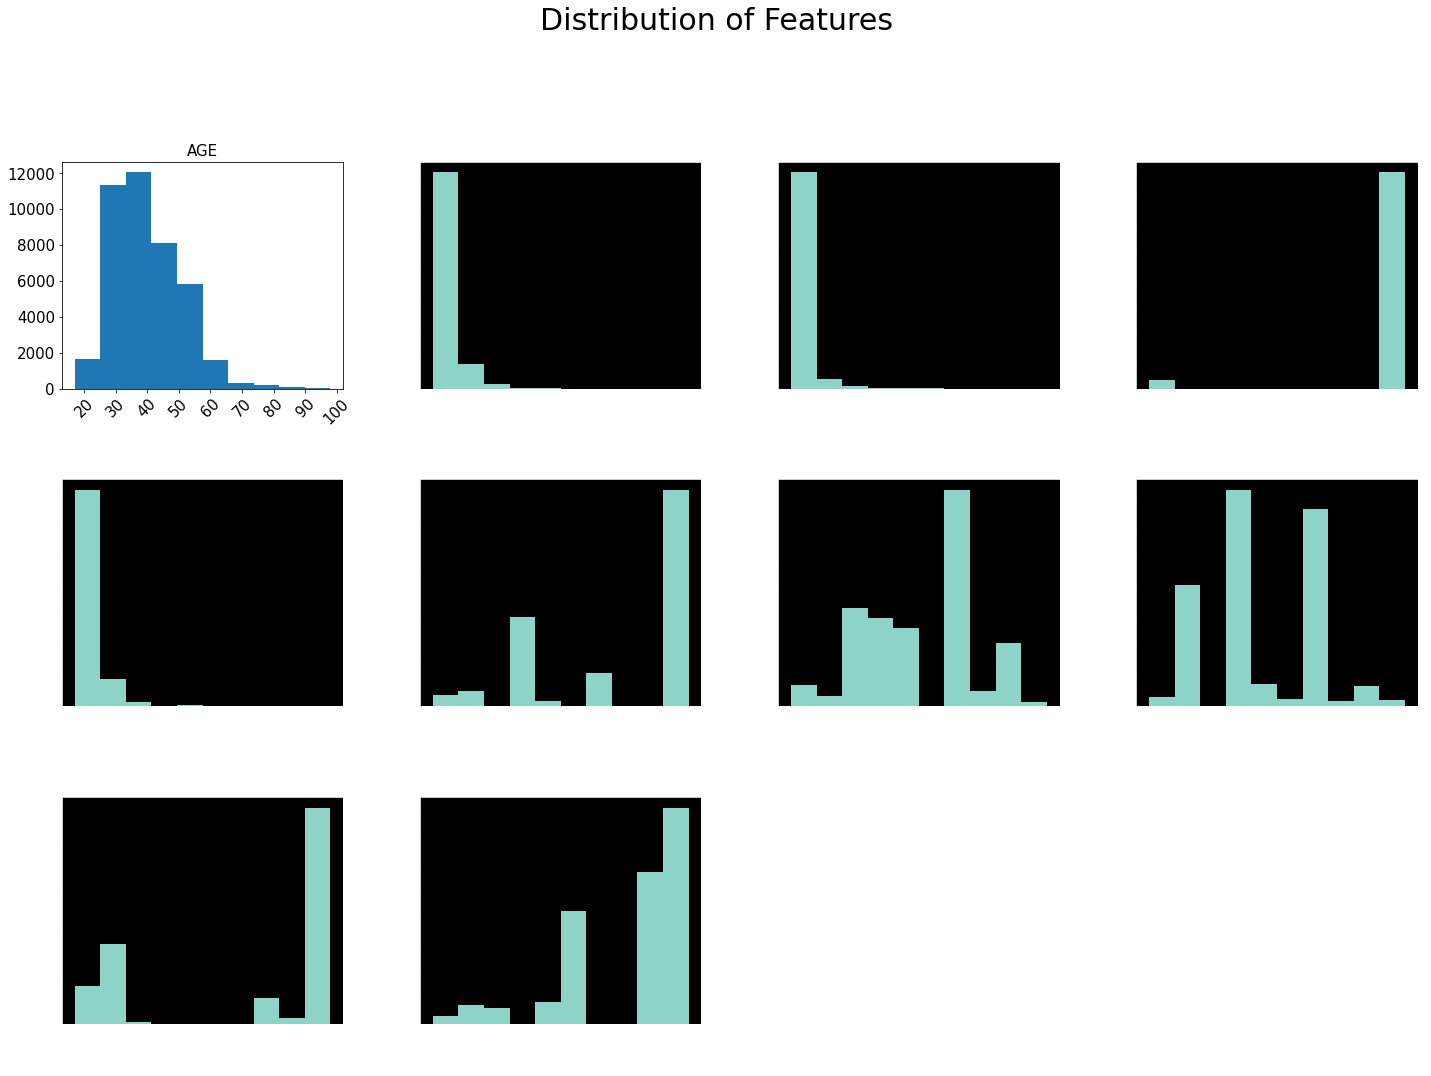

In [10]:
# Distribution of Features

fig = plt.figure(figsize=(20,15)) ## Plot Size 
st = fig.suptitle("Distribution of Features", fontsize=30,
                  verticalalignment='center') # Plot Main Title 

for col,num in zip(df.toPandas().describe().columns, range(1,23)):
    ax = fig.add_subplot(3,4,num)
    ax.hist(df.toPandas()[col])
    plt.style.use('dark_background') 
    plt.grid(False)
    plt.xticks(rotation=45,fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(col.upper(),fontsize=15)
plt.tight_layout()
# st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace = 0.4)
plt.show()

In [11]:
# Distribution of each categorical variable
for i in df.dtypes:
    if i[1]=='string':
        print(df.groupBy(i[0]).count().orderBy('count', ascending=False).toPandas())

              job  count
0          admin.  10422
1     blue-collar   9254
2      technician   6743
3        services   3969
4      management   2924
5         retired   1720
6    entrepreneur   1456
7   self-employed   1421
8       housemaid   1060
9      unemployed   1014
10        student    875
11        unknown    330
    marital  count
0   married  24928
1    single  11568
2  divorced   4612
3   unknown     80
             education  count
0    university.degree  12168
1          high.school   9515
2             basic.9y   6045
3  professional.course   5243
4             basic.4y   4176
5             basic.6y   2292
6              unknown   1731
7           illiterate     18
   default  count
0       no  32588
1  unknown   8597
2      yes      3
   housing  count
0      yes  21576
1       no  18622
2  unknown    990
      loan  count
0       no  33950
1      yes   6248
2  unknown    990
     contact  count
0   cellular  26144
1  telephone  15044
  month  count
0   may  13769
1   

### Correlation

In [12]:
sqlContext.sql("SELECT * from bank").toPandas().corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
age,1.00,-0.00,0.00,-0.03,0.02,-0.00,0.00,0.13,0.01,-0.02
duration,-0.00,1.00,-0.07,-0.05,0.02,-0.03,0.01,-0.01,-0.03,-0.04
campaign,0.00,-0.07,1.00,0.05,-0.08,0.15,0.13,-0.01,0.14,0.14
pdays,-0.03,-0.05,0.05,1.00,-0.59,0.27,0.08,-0.09,0.30,0.37
previous,0.02,0.02,-0.08,-0.59,1.00,-0.42,-0.20,-0.05,-0.45,-0.50
emp_var_rate,-0.00,-0.03,0.15,0.27,-0.42,1.00,0.78,0.20,0.97,0.91
cons_price_idx,0.00,0.01,0.13,0.08,-0.20,0.78,1.00,0.06,0.69,0.52
cons_conf_idx,0.13,-0.01,-0.01,-0.09,-0.05,0.20,0.06,1.00,0.28,0.10
euribor3m,0.01,-0.03,0.14,0.30,-0.45,0.97,0.69,0.28,1.00,0.95
nr_employed,-0.02,-0.04,0.14,0.37,-0.50,0.91,0.52,0.10,0.95,1.00


### Bivariate analysis of target versus input variables

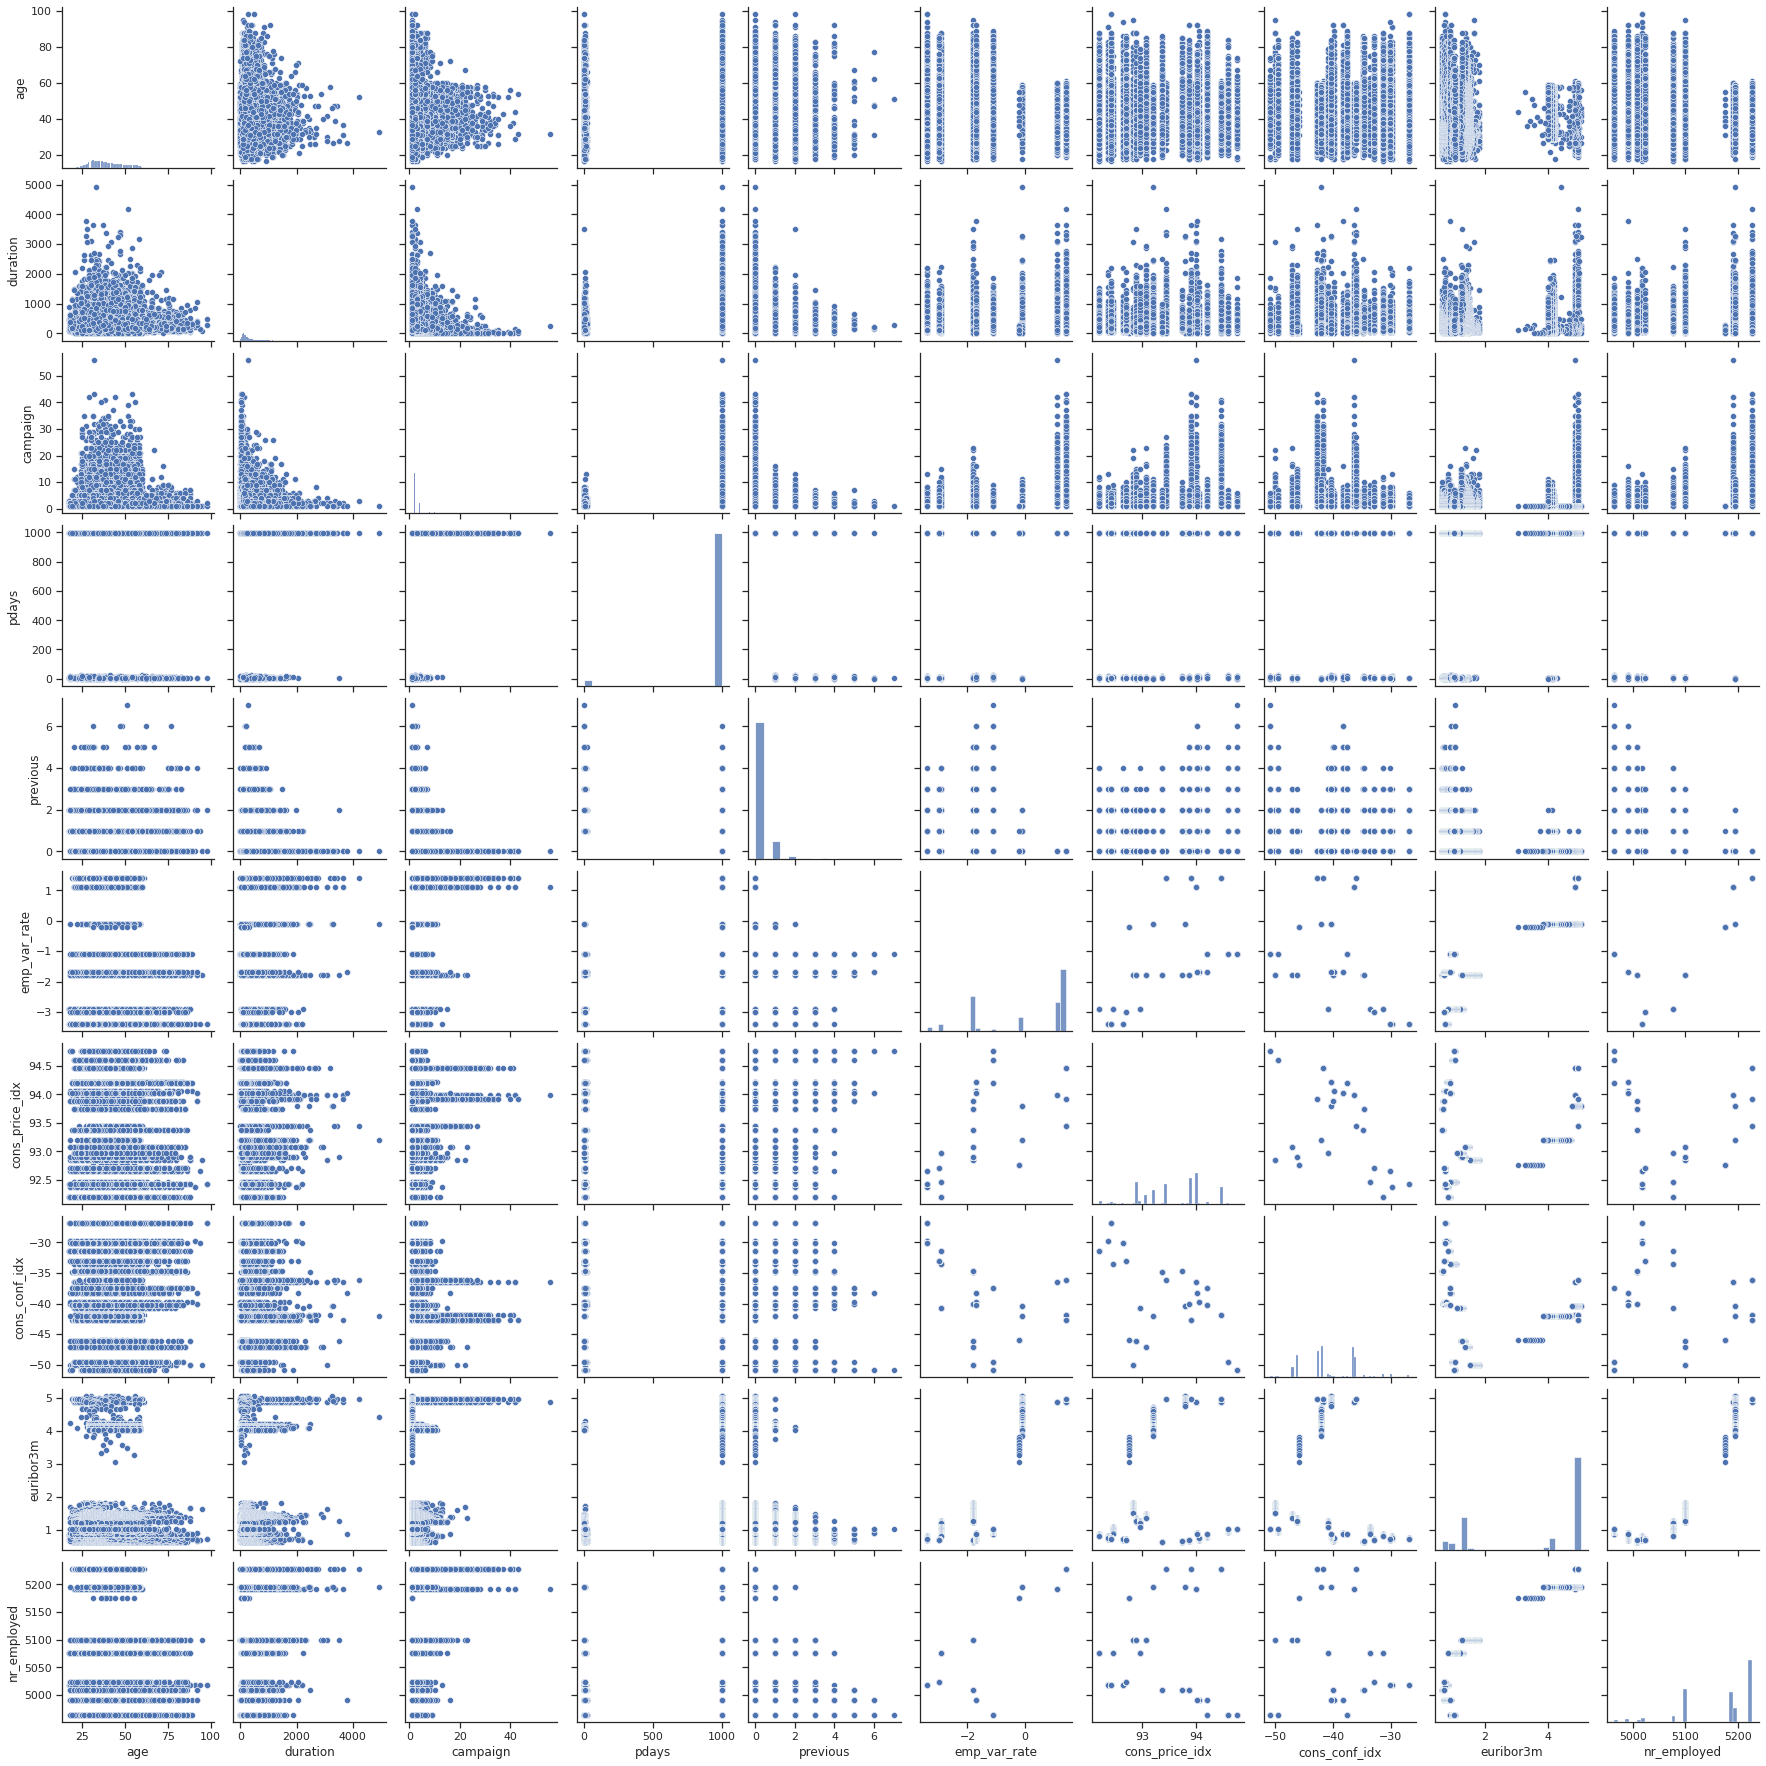

In [13]:
# Pairplots

sns.set(style="ticks")

sns.pairplot(df.toPandas())
plt.show()

In [14]:
var_categorical = [t[0] for t in df.dtypes if t[1] == 'string']
var_numeric = [t[0] for t in df.dtypes if t[1] != 'string']

Job


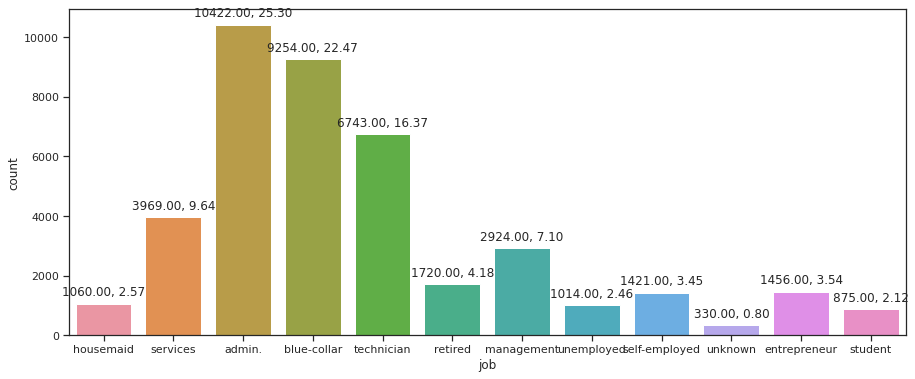

Marital


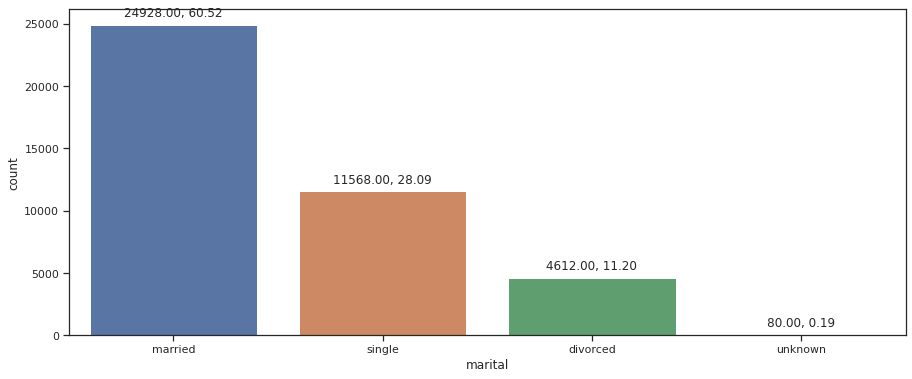

Education


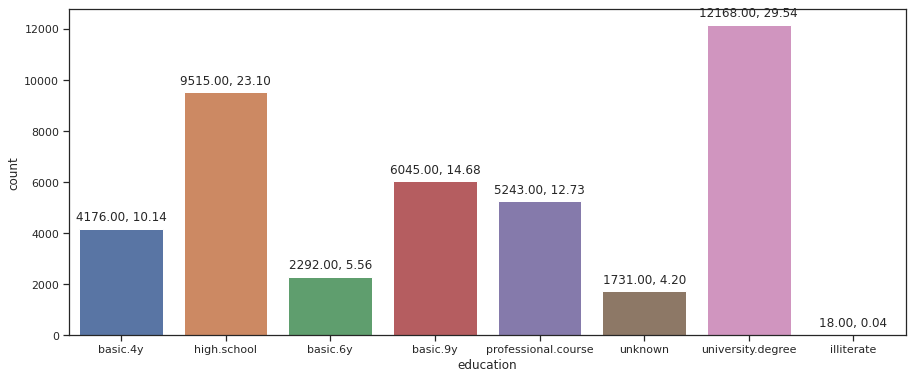

Default


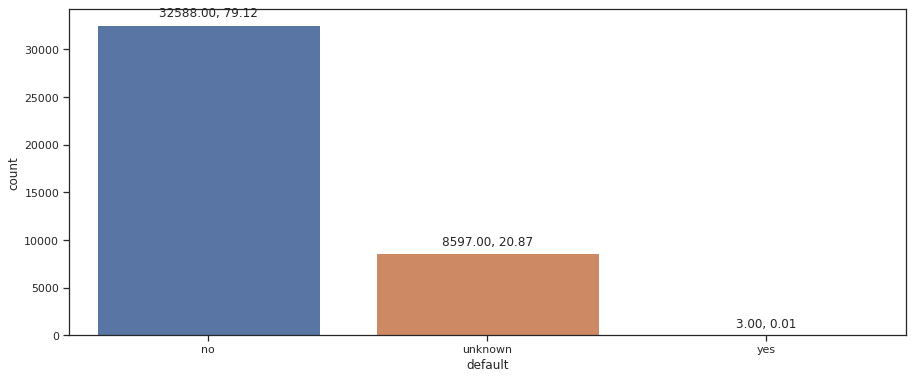

Housing


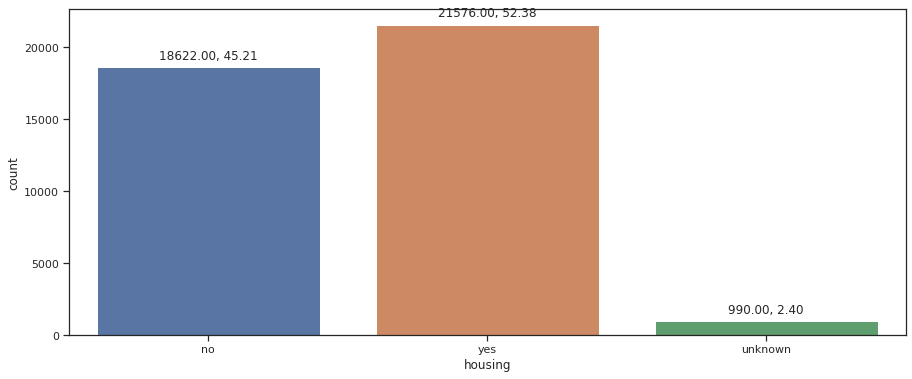

Loan


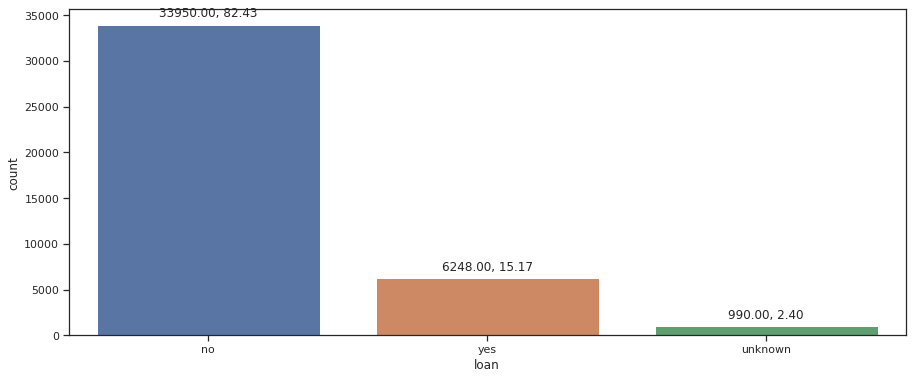

Contact


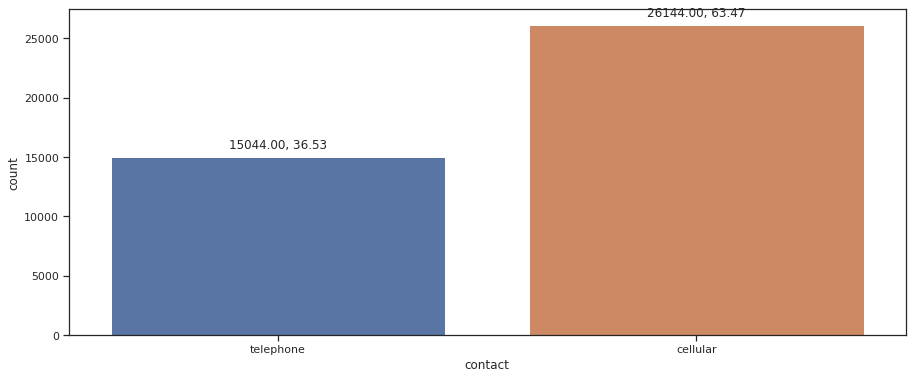

Month


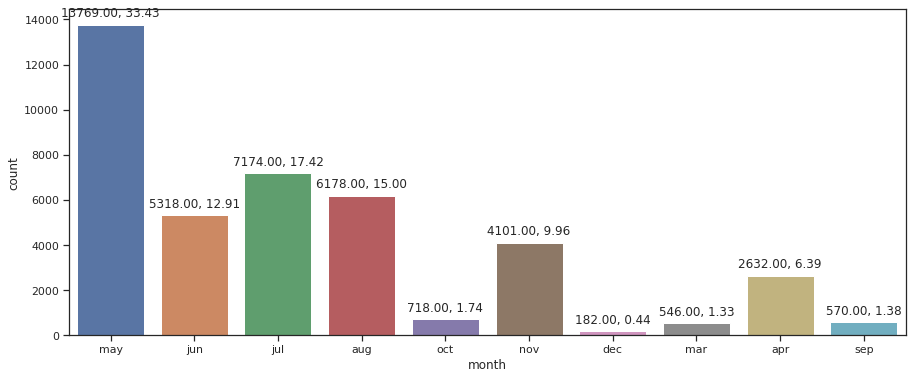

Day_Of_Week


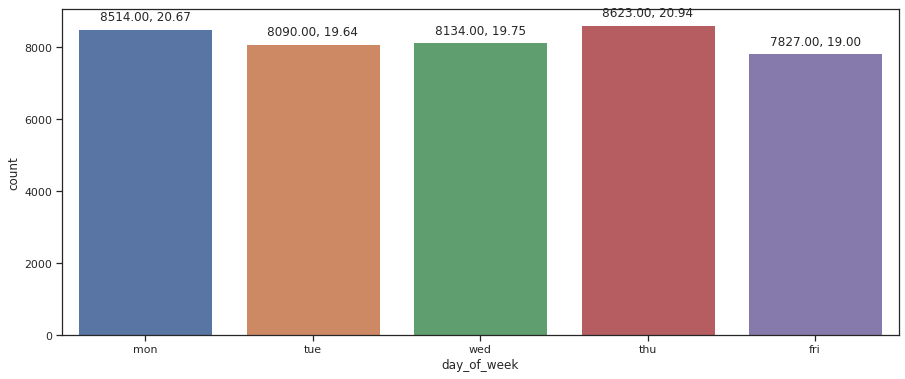

Poutcome


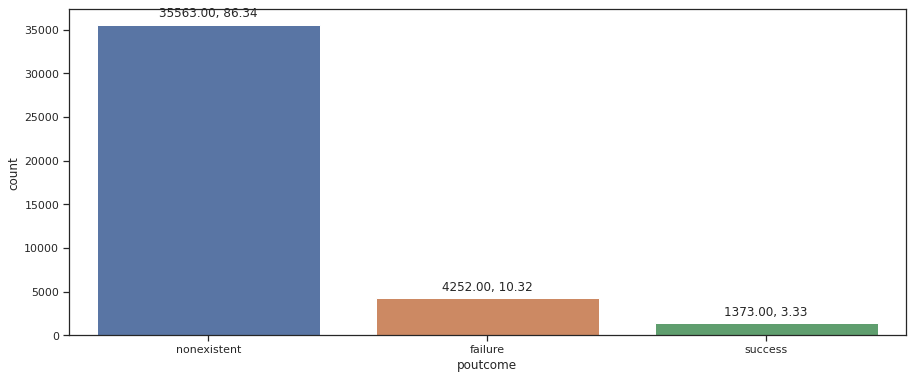

Y


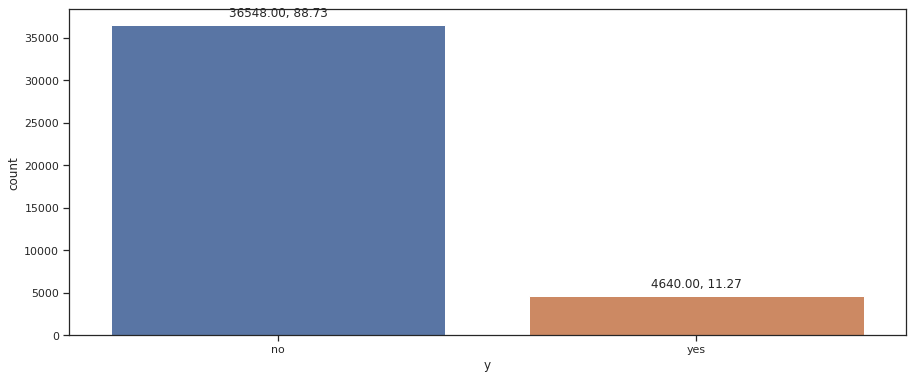

Age


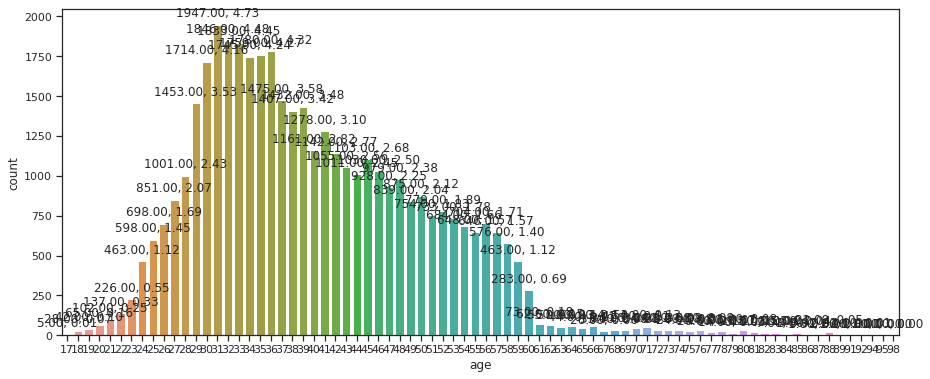

Duration


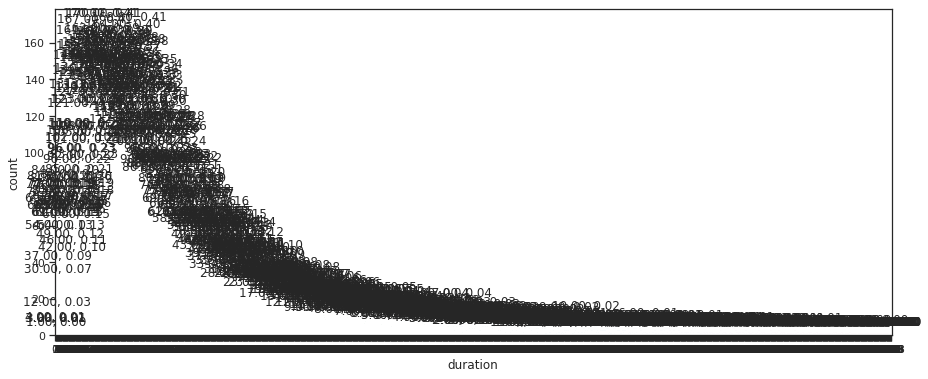

Campaign


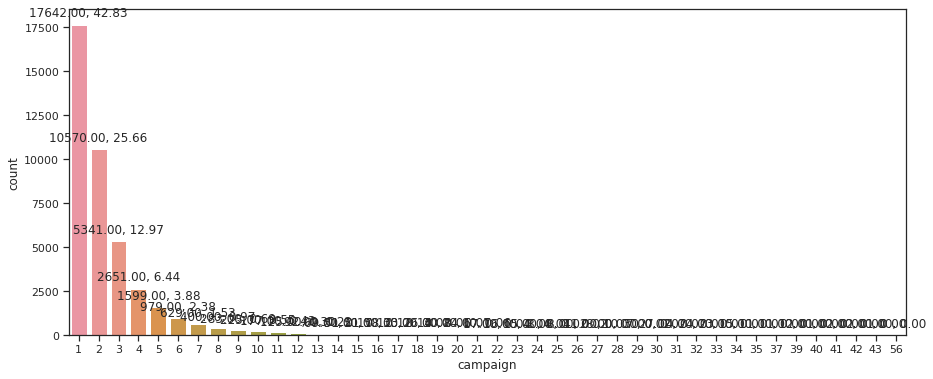

Pdays


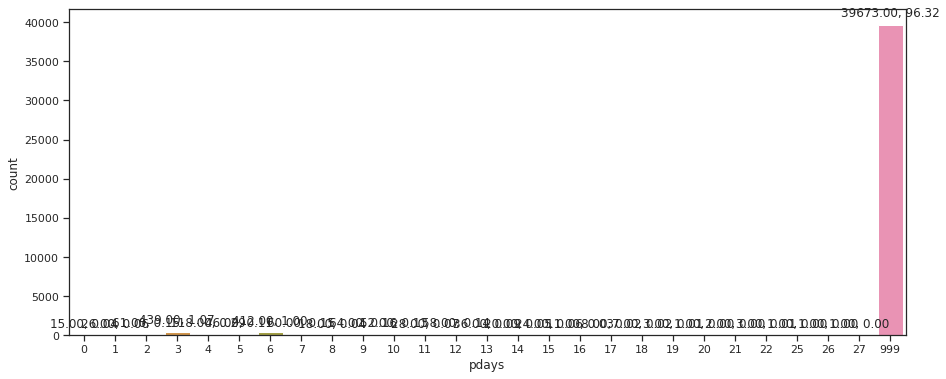

Previous


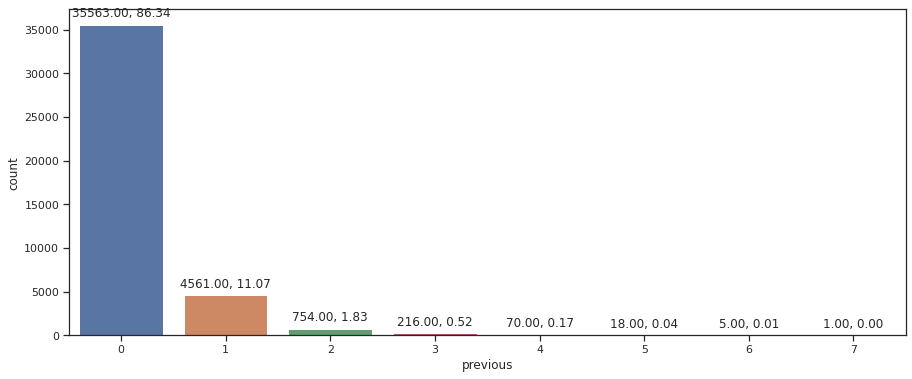

Emp_Var_Rate


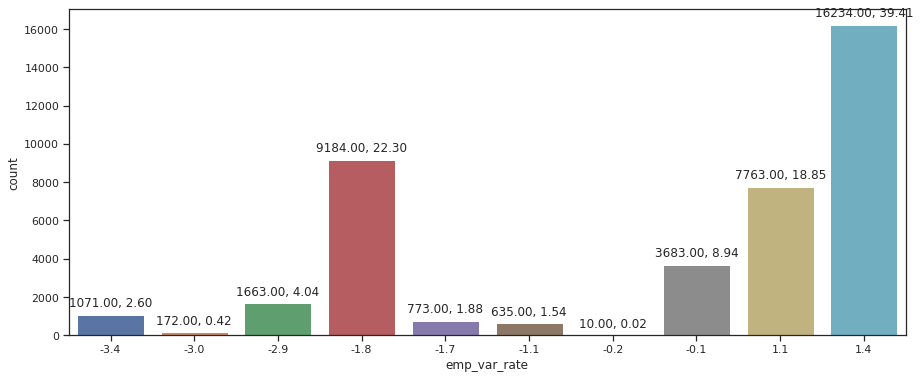

Cons_Price_Idx


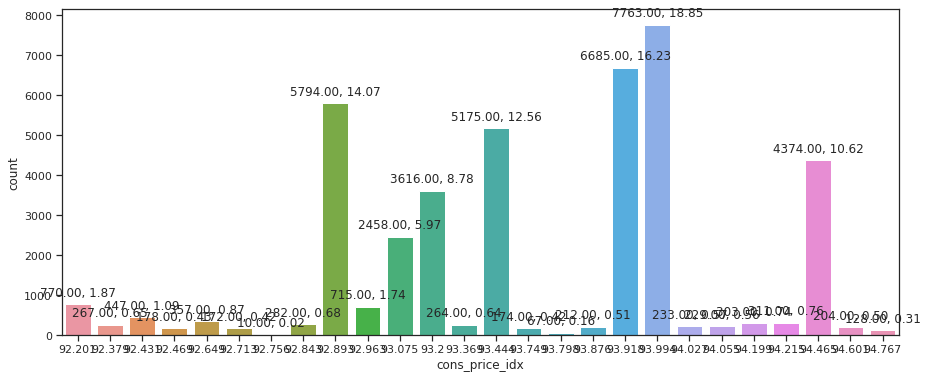

Cons_Conf_Idx


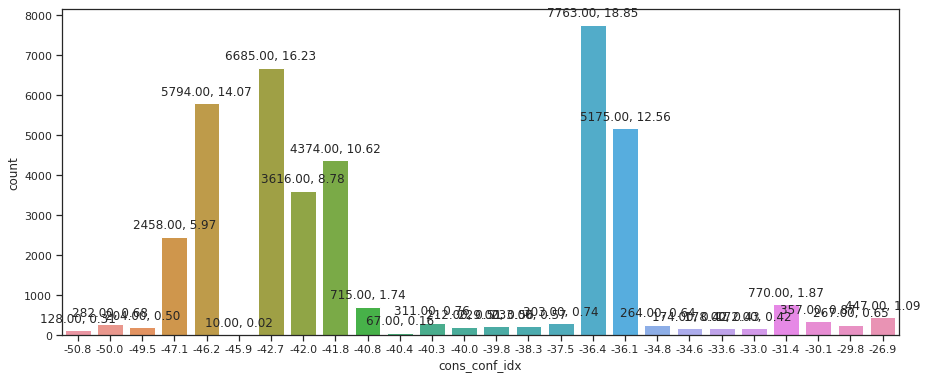

Euribor3M


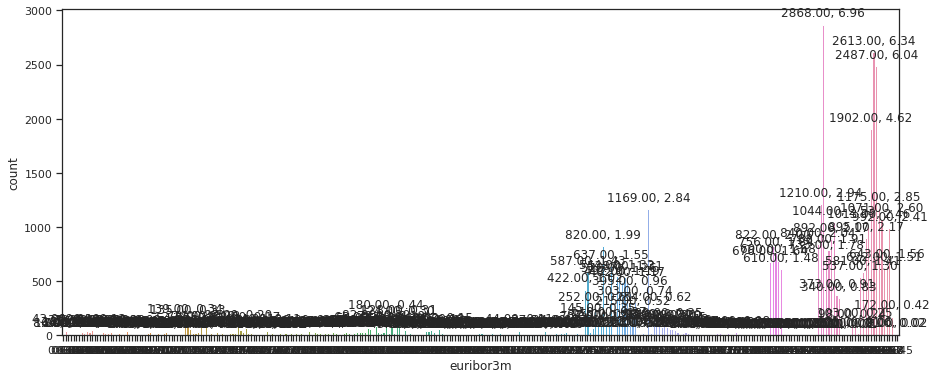

Nr_Employed


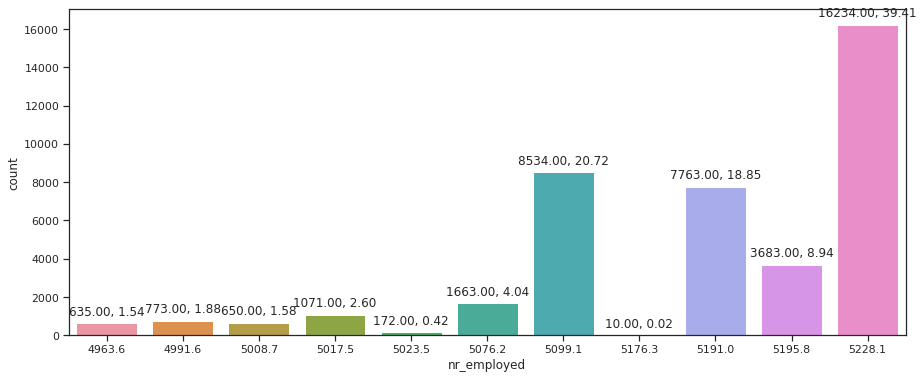

In [15]:
# Function to label the count on top of each bar in graph
def label_values(ax, spacing=5):
    total = 0
    for rect in ax.patches:
        total += rect.get_height()

    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        space = spacing
        
        va = 'bottom'
        
        if y_value < 0:
            space *= -1
            va = 'top'
        label = "{:.2f}, {:.2f}".format(y_value, y_value/total*100)
        ax.annotate(
            label,                      
            (x_value, y_value),         
            xytext=(0, space),          
            textcoords="offset points", 
            ha='center',                
            va=va)        
        
for column in var_categorical:
    plt.figure(figsize=(15, 6))
    print(column.title())
    ax = sns.countplot(x = df.toPandas()[column])
    label_values(ax)
    plt.show()

for column in var_numeric:
    plt.figure(figsize=(15, 6))
    print(column.title())
    ax = sns.countplot(x = df.toPandas()[column])
    label_values(ax)
    plt.show()

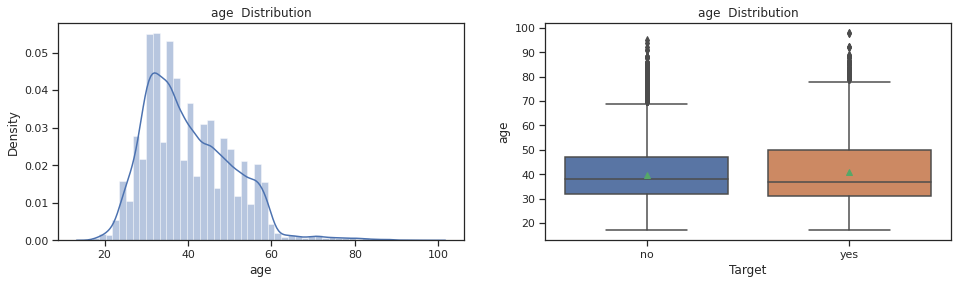

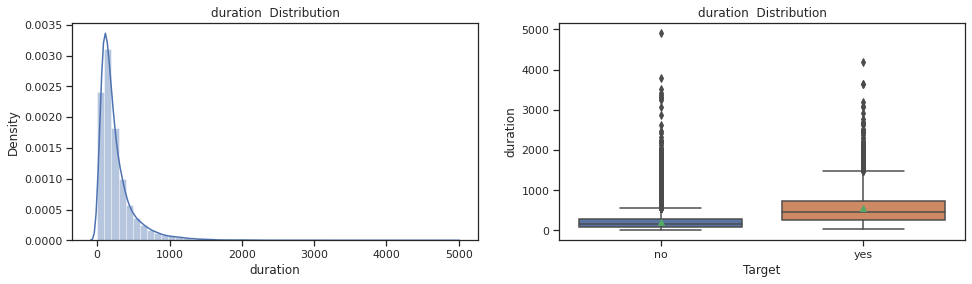

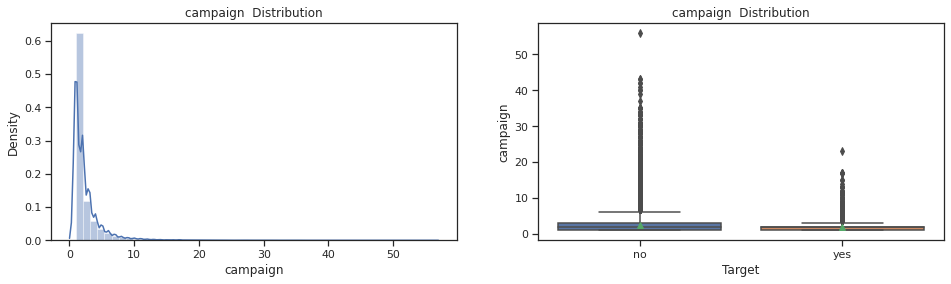

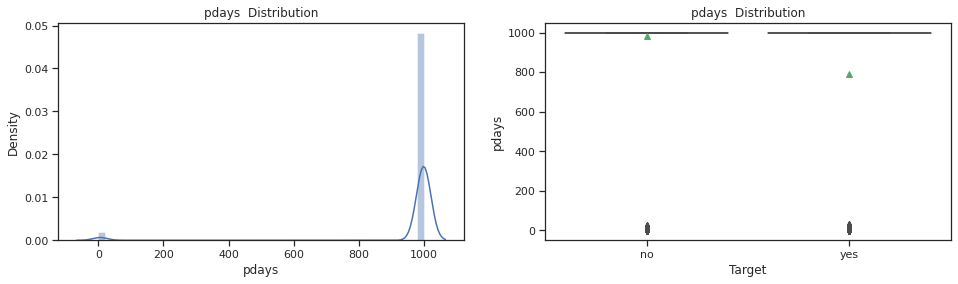

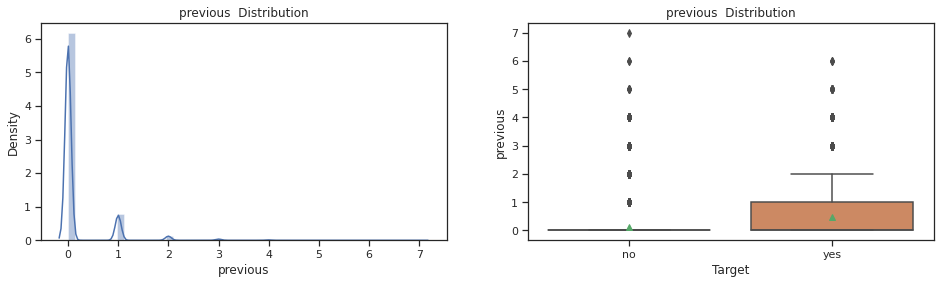

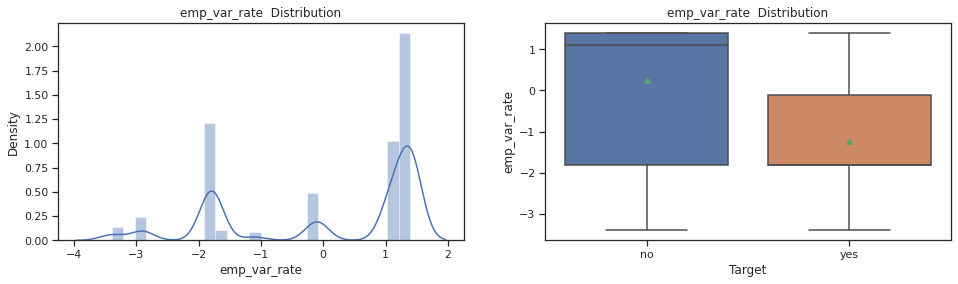

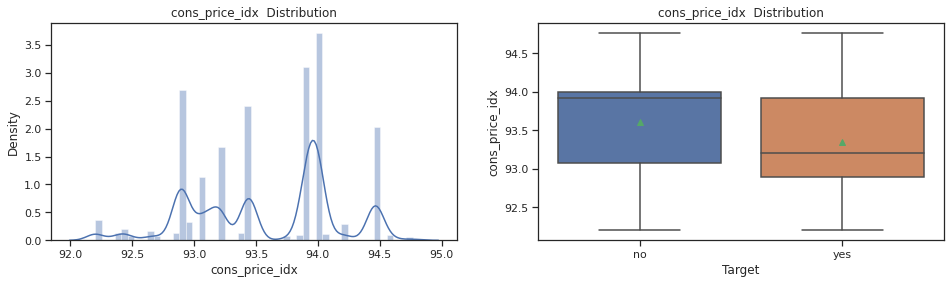

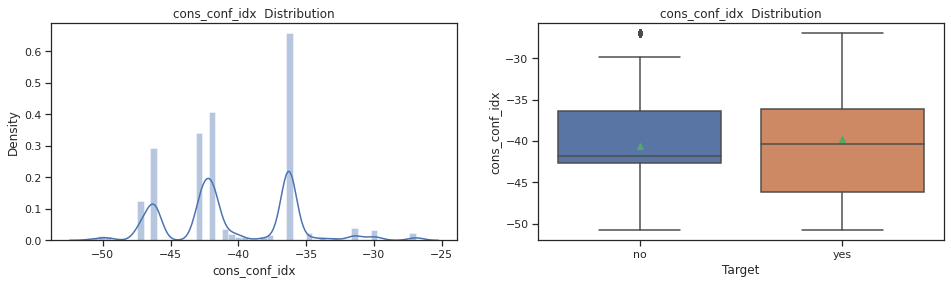

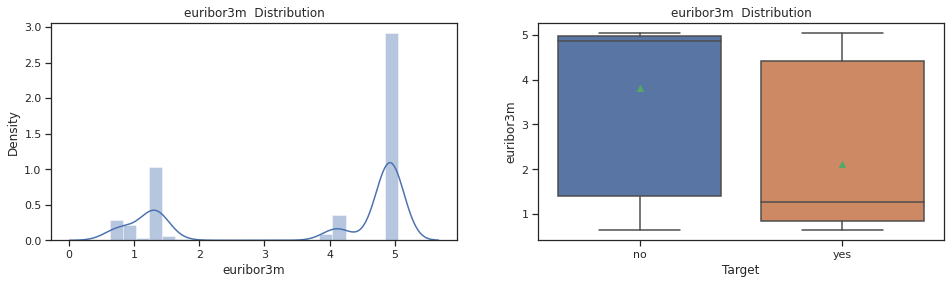

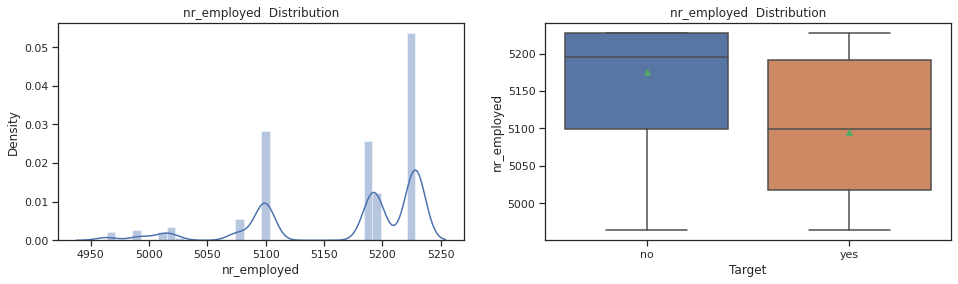

In [16]:
# Numeric

for column in var_numeric:
    plt.figure(figsize=(16,4))

    plt.subplot(1,2,1)
    # plt.subplot(1,3,1)
    sns.distplot(df.toPandas()[column])
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.title(f'{column}  Distribution')

    plt.subplot(1,2,2)
    # plt.subplot(1,3,1)
    sns.boxplot(x='y', y=column, data =df.toPandas(), showmeans=True )
    plt.xlabel('Target')
    plt.ylabel(column)
    plt.title(f'{column}  Distribution')

    # plt.subplot(1,3,3)
    # counts, bins = np.histogram(df.toPandas()[column], bins=20, normed=True)
    # cdf = np.cumsum (counts)
    # plt.plot (bins[1:], cdf/cdf[-1])
    # #plt.xticks(range(15,100,5))
    # plt.yticks(np.arange(0,1.1,.1))
    # plt.title(f'{column}  cdf')
    # plt.show()

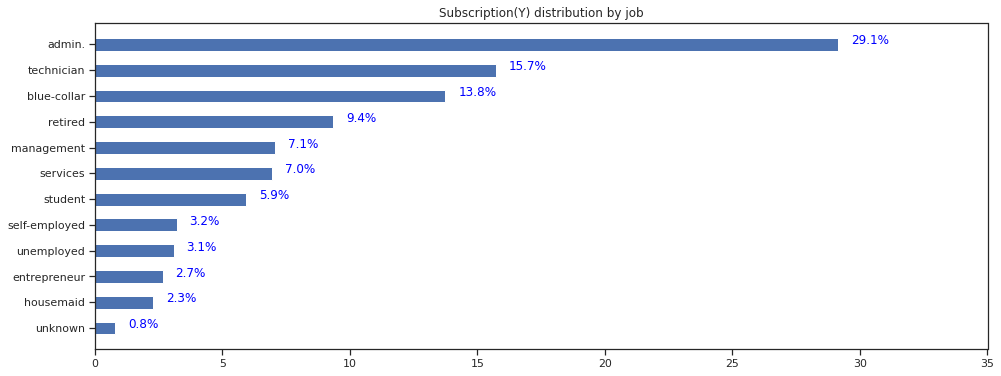

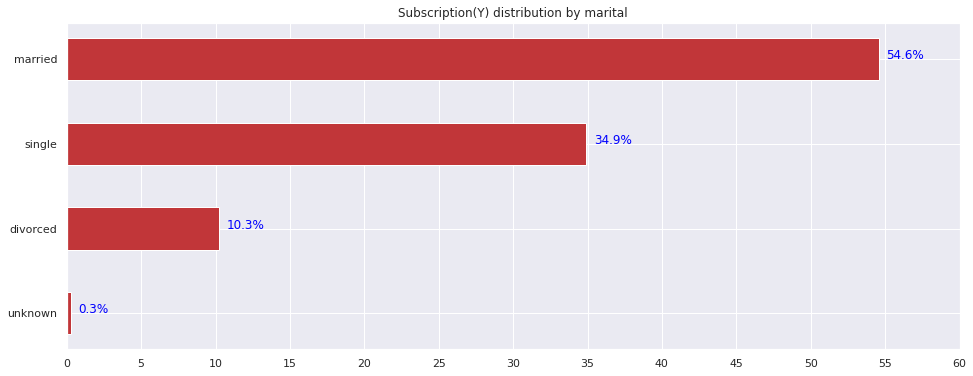

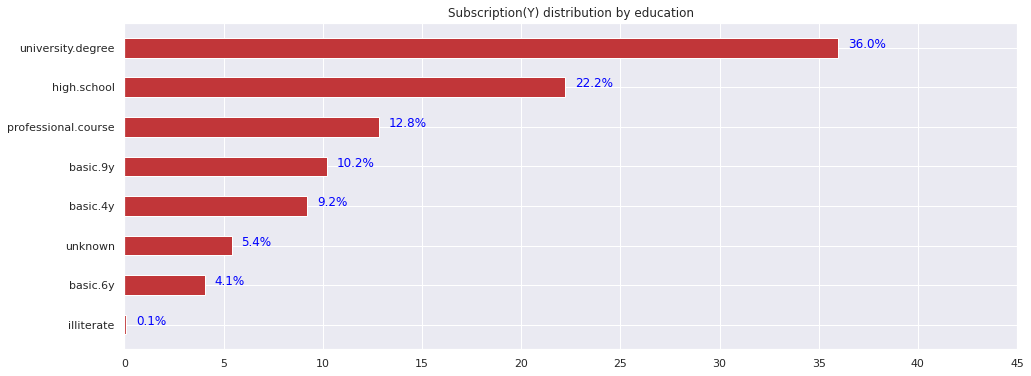

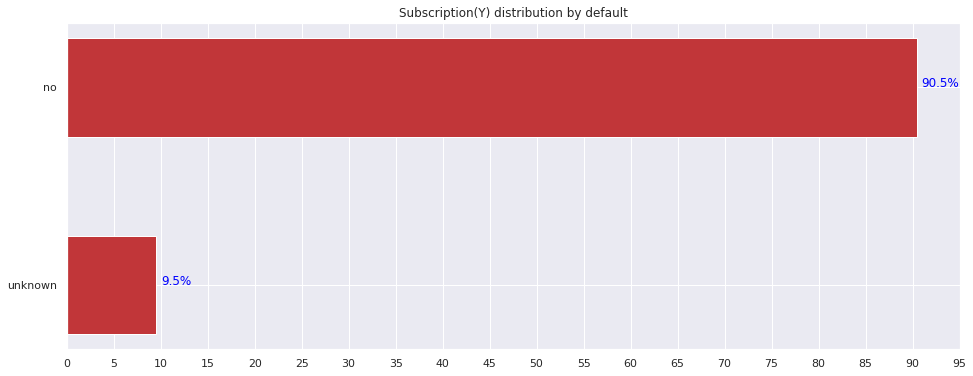

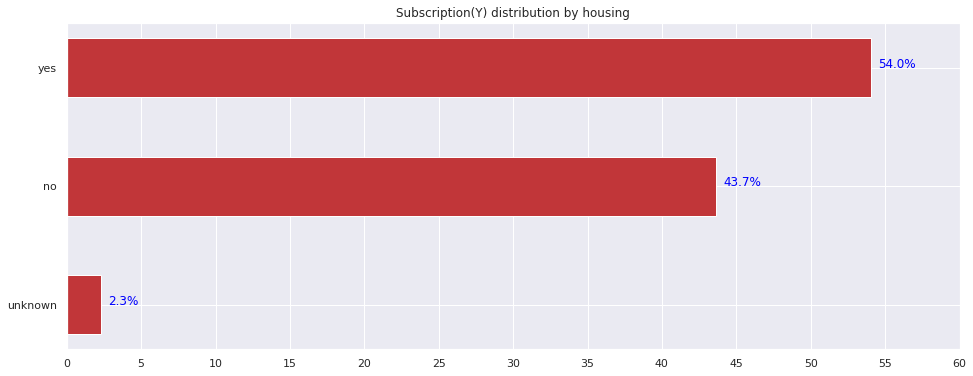

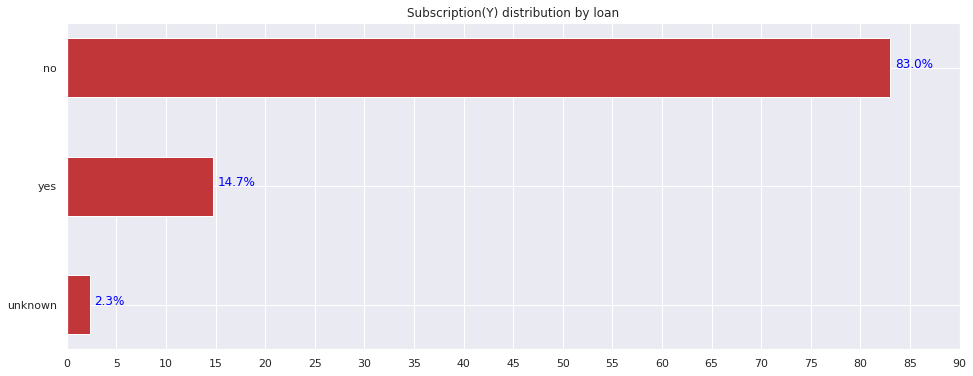

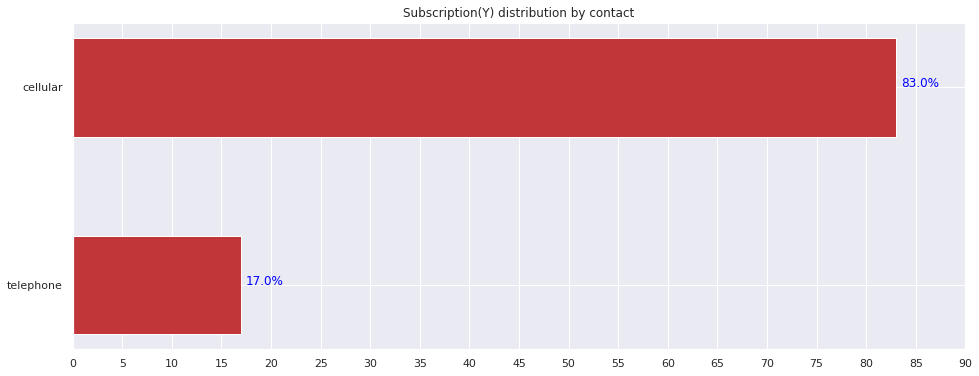

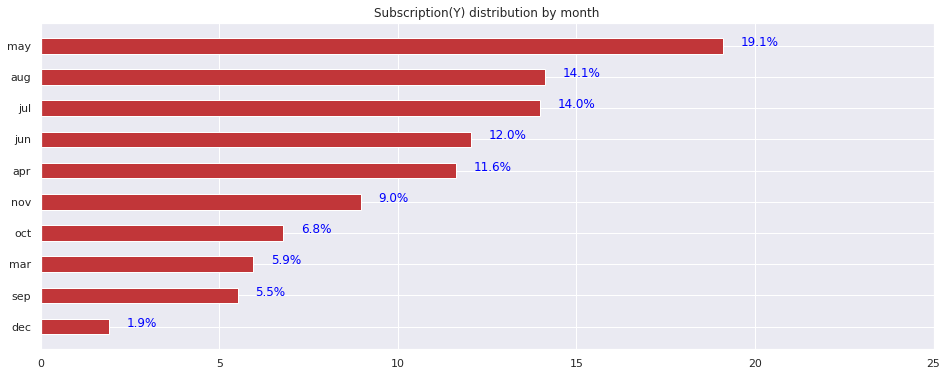

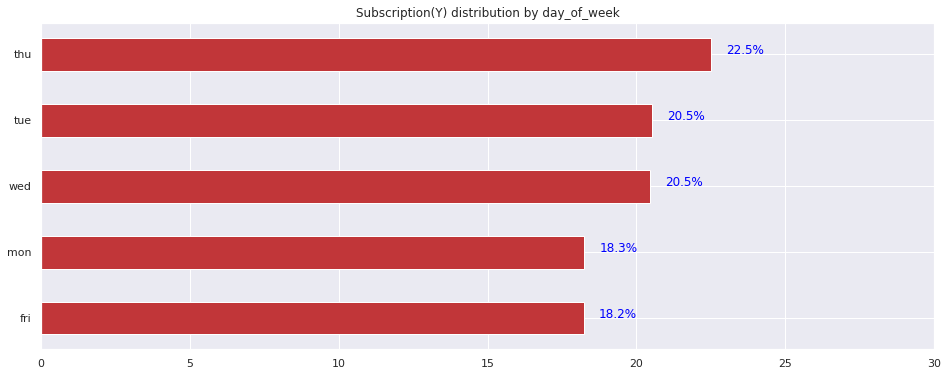

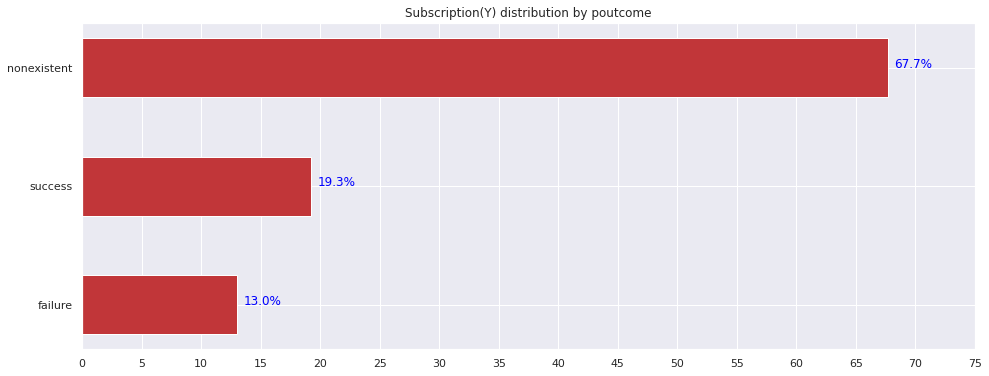

In [17]:
# Categories

dfgrouped = df.toPandas().groupby('y')
def plot_barh(array,incrementer, bias, text_color ='blue', palette_style = 'darkgrid',palette_color = 'RdBu'):

    sns.set_style(palette_style)
    sns.set_palette(palette_color)

    plt.barh(array.index, width = array.values, height = .5)
    plt.yticks(np.arange(len(array)))
    plt.xticks( range(0, round(max(array)) +bias, incrementer ))

    for index, value in enumerate(array.values):
        plt.text(value +.5, index, s= '{:.1f}%'.format(value), color = text_color)

    #plt.show()
    return plt

def feature_perc(feature,groupby):

    count = dfgrouped.get_group(groupby)[feature].value_counts()
    total_count = count.sum() #df.toPandas()[feature].value_counts()[count.index]

    perc = (count/total_count)*100
    return perc 
    
for column in var_categorical[:-1]:

    yes_perc = feature_perc(column, groupby='yes')
    no_perc = feature_perc(column, groupby='no')

    plt.figure(figsize=(16,6))

    # plt.subplot(1,2,1)
    plt.subplot(1,1,1)
    plt.title(f'Subscription(Y) distribution by {column}')
    plot_barh(yes_perc.sort_values(),5,10)

    # plt.subplot(1,2,2)
    # plt.title(f'Failure rate by {column}')
    # plot_barh(no_perc.sort_values(),5,10)
    # plt.show()

In [18]:
# Replace No with 0 and Yes with 1
# https://sparkbyexamples.com/pyspark/pyspark-replace-column-values/

from pyspark.sql.functions import regexp_replace
from pyspark.sql.types import IntegerType

df=df.withColumn('y', regexp_replace('y', 'no', '0'))
df=df.withColumn('y', regexp_replace('y', 'yes', '1'))
df=df.withColumn("y", df["y"].cast(IntegerType()))

In [19]:
# Future steps on a copy of df
df_pipeline = df.alias('df_pipeline')
cols = df_pipeline.columns

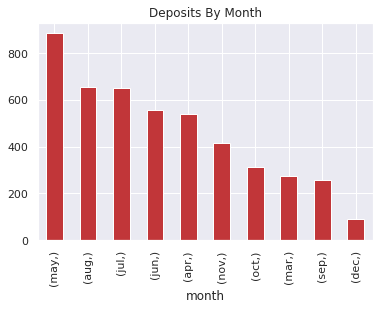

In [20]:
# Deposits By Month
sqlContext.sql("SELECT month from bank where y='yes'").toPandas().value_counts().plot(kind='bar', title="Deposits By Month")

# Pipeline

In [21]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, StandardScaler, MinMaxScaler

In [22]:
# Selecting categorical columns only
categoricalColumns = ['job', 'default', 'housing', 'loan', 'marital', 'education', 'contact', 'month', 'day_of_week', 'poutcome']

# Creating an empty list for pipeline and assembler
stages = []

# Applying for loop to index and encode all the selected columns
# Applying string indexer to all the categorical columns and storing it in a new column with +indexed
# Applying one hot encoder to all the indexed columns and storing it in a new column with +encoded

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + '_indexed')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "_encoded"])
    stages += [stringIndexer, encoder]
    
# Indexing predictor column 'y' as label and features    
label_stringIdx = StringIndexer(inputCol = 'y', outputCol = 'label')

# Creating stages for both numerical and categorical columns
stages += [label_stringIdx]
numericCols = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed'] 

# Adding both to assembler
assemblerInputs = numericCols + [c + "_encoded" for c in categoricalColumns]

# Vectorizing to create a new features column with indexed and encoded values
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="vectorized_features", handleInvalid="skip")
stages += [assembler]

# Standard Scaling
scaler = StandardScaler(inputCol="vectorized_features", outputCol="features")
stages += [scaler]

In [23]:
# Combining all the stages into one, fitting data and transforming it
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(df_pipeline)
df_pipeline = pipelineModel.transform(df_pipeline)
data = df_pipeline.alias("data")

In [24]:
# Input features to the vector
df_pipeline.schema["vectorized_features"].metadata["ml_attr"]["attrs"]

{'numeric': [{'idx': 0, 'name': 'age'},
  {'idx': 1, 'name': 'duration'},
  {'idx': 2, 'name': 'campaign'},
  {'idx': 3, 'name': 'pdays'},
  {'idx': 4, 'name': 'previous'},
  {'idx': 5, 'name': 'emp_var_rate'},
  {'idx': 6, 'name': 'cons_price_idx'},
  {'idx': 7, 'name': 'cons_conf_idx'},
  {'idx': 8, 'name': 'euribor3m'},
  {'idx': 9, 'name': 'nr_employed'}],
 'binary': [{'idx': 10, 'name': 'job_encoded_admin.'},
  {'idx': 11, 'name': 'job_encoded_blue-collar'},
  {'idx': 12, 'name': 'job_encoded_technician'},
  {'idx': 13, 'name': 'job_encoded_services'},
  {'idx': 14, 'name': 'job_encoded_management'},
  {'idx': 15, 'name': 'job_encoded_retired'},
  {'idx': 16, 'name': 'job_encoded_entrepreneur'},
  {'idx': 17, 'name': 'job_encoded_self-employed'},
  {'idx': 18, 'name': 'job_encoded_housemaid'},
  {'idx': 19, 'name': 'job_encoded_unemployed'},
  {'idx': 20, 'name': 'job_encoded_student'},
  {'idx': 21, 'name': 'default_encoded_no'},
  {'idx': 22, 'name': 'default_encoded_unknown'},


In [25]:
data.show(5)

+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+-----------+--------------+---------------+---------------+---------------+---------------+------------+-------------+---------------+---------------+-----------------+-----------------+---------------+---------------+-------------+-------------+-------------------+-------------------+----------------+----------------+-----+--------------------+--------------------+
|age|      job|marital|  education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|job_indexed|   job_encoded|default_indexed|default_encoded|housing_indexed|housing_encoded|loan_indexed| loan_encoded|marital_indexed|marital_encoded|education_indexed|education_encoded|contact_indexed|contact_encoded|month_indexed|month

In [26]:
# Adding all the original columns to the new data frame
selectedCols = ['label', 'features'] + cols
data = data.select(selectedCols)
data.show(5)

+-----+--------------------+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|label|            features|age|      job|marital|  education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+-----+--------------------+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|  0.0|(53,[0,1,2,3,5,6,...| 56|housemaid|married|   basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0|  0|
|  0.0|(53,[0,1,2,3,5,6,...| 57| services|married|high.school|unknown|     no|  no|telephone|  may| 

# Supervised learning

## Class Weights distribution

In [27]:
# Imbalanced data: 
# Computing “balanced” weights with data from a PySpark DataFrame. https://danvatterott.com/blog/2019/11/18/balancing-model-weights-in-pyspark/

y_collect = data.select("y").groupBy("y").count().collect()
unique_y = [x["y"] for x in y_collect]
total_y = sum([x["count"] for x in y_collect])
unique_y_count = len(y_collect)
bin_count = [x["count"] for x in y_collect]

class_weights_spark = {i: ii for i, ii in zip(unique_y, total_y / (unique_y_count * np.array(bin_count)))}
print(class_weights_spark)

{1: 4.438362068965517, 0: 0.5634781656999015}


In [28]:
from pyspark.sql import functions as F
from itertools import chain
mapping_expr = F.create_map([F.lit(x) for x in chain(*class_weights_spark.items())])

data = data.withColumn("weight", mapping_expr.getItem(F.col("y")))
data.show(5)

+-----+--------------------+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+------------------+
|label|            features|age|      job|marital|  education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|            weight|
+-----+--------------------+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+------------------+
|  0.0|(53,[0,1,2,3,5,6,...| 56|housemaid|married|   basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0|  0|0.5634781656999015|
|  0.0|(53,[0,1,2,3,5,6,

## Stratify splits

In [29]:
# Stratify 
# split dataframes between 0s and 1s
zeros = data.filter(data["y"]==0)
ones = data.filter(data["y"]==1)

# split datasets into training and testing
train0, test0 = zeros.randomSplit([0.7,0.3], seed=42)
train1, test1 = ones.randomSplit([0.7,0.3], seed=42)

# stack datasets back together
train = train0.union(train1)
test = test0.union(test1)

print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 28975
Test Dataset Count: 12213


## Confusion Matrix

In [30]:
# Confusion Matrix code
from sklearn.metrics import confusion_matrix
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator 

metrics_list = list()
class_names=[0.0, 1.0]

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Models

## Logistic Regression Model

In [31]:
# Importing packages for logistic regression
from pyspark.ml.classification import LogisticRegression

# Fitting a logistic regression model to train data using normalized features
model = LogisticRegression(featuresCol = 'features', labelCol = 'label', weightCol="weight")
# model = LogisticRegression(featuresCol = 'features', labelCol = 'label', family = "binomial", maxIter=100, regParam=0.3, elasticNetParam=0.1, weightCol="weight")
lrModel = model.fit(train)

predictions = lrModel.transform(test)
predictions.select( 'features','label', 'rawPrediction', 'prediction', 'probability').show(5)

+--------------------+-----+--------------------+----------+--------------------+
|            features|label|       rawPrediction|prediction|         probability|
+--------------------+-----+--------------------+----------+--------------------+
|(53,[0,1,2,3,4,5,...|  0.0|[2.59094136041744...|       0.0|[0.93027630066708...|
|(53,[0,1,2,3,4,5,...|  0.0|[1.07830280903530...|       0.0|[0.74617267136112...|
|(53,[0,1,2,3,4,5,...|  0.0|[2.22867246999743...|       0.0|[0.90279492223633...|
|(53,[0,1,2,3,4,5,...|  0.0|[0.41684314607445...|       0.0|[0.60272759621648...|
|(53,[0,1,2,3,4,5,...|  0.0|[-0.0277122401558...|       1.0|[0.49307238330450...|
+--------------------+-----+--------------------+----------+--------------------+
only showing top 5 rows



Confusion matrix, without normalization
[[9329 1557]
 [ 157 1170]]


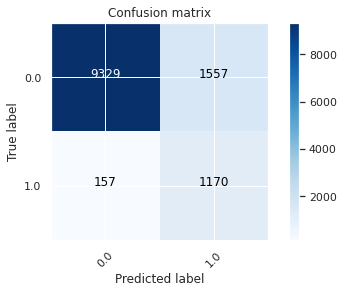

In [32]:
# Confusion Matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

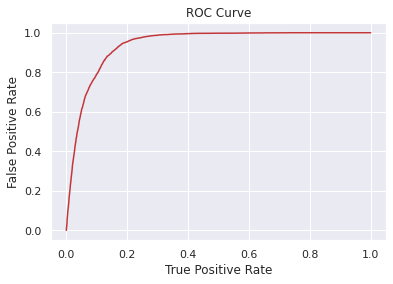

Training set areaUnderROC: 0.9390006888642183


In [33]:
# Computing training areaUnderROC
trainingSummary = lrModel.summary

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [34]:
# Test set areaUnderROC

evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9360651201788334


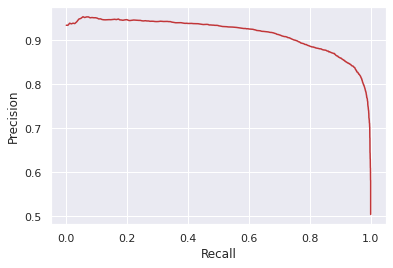

In [35]:
# Plotting recall vs precision graph
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [36]:
# Metrics function to evaluate recall, precision and f1score

from pyspark.mllib.evaluation import MulticlassMetrics

results = predictions.select(['prediction', 'label'])
predictionAndLabels=results.rdd
metrics = MulticlassMetrics(predictionAndLabels)

cm=metrics.confusionMatrix().toArray()
accuracy=(cm[0][0]+cm[1][1])/cm.sum()
precision=(cm[1][1])/(cm[1][1]+cm[0][1])
recall=(cm[1][1])/(cm[1][1]+cm[1][0])
f1score =((2*precision*recall )/ (precision + recall))


# Calculating test area under roc
evaluator = BinaryClassificationEvaluator()
auc=evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})

metrics_dict = {'model': model, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1score': f1score, 'auc': auc}
metrics_list.append(metrics_dict)
metrics_dict

{'model': LogisticRegression_10146ae4e77f,
 'accuracy': 0.8596577417505936,
 'precision': 0.429042904290429,
 'recall': 0.881688018085908,
 'f1score': 0.5772076961026147,
 'auc': 0.9360691005960105}

In [37]:
# Printing coefficients and intercept for the model

print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

Coefficients: [-0.014564804188484557,1.8483575696585401,-0.10942823360968273,-0.18098328832515226,-0.03272657218879358,-3.539902041559742,1.3244062614550571,-0.012900809978848385,1.2438139614829242,0.1481297109536839,-0.2079347211490223,-0.24707661664770217,-0.16409234926704405,-0.18478269051958518,-0.1207326459447089,0.023734337008467228,-0.0910519731608282,-0.09302746382093566,-0.0594615759713611,-0.042566307265585336,-0.023560752800544815,0.08704742569131578,-0.036130581031897424,-0.002326405664416807,-0.009499846009726516,0.003904253098156349,-0.020775222778184475,-0.03698421273202684,0.024556879461949607,-0.021163070114951416,-0.4604567464809827,-0.5478260602583087,-0.4618043344827556,-0.4021095002889377,-0.44456429065770975,-0.2757499719572785,-0.231973605854488,0.2187988190937288,-0.4031547439470695,0.008803827388035378,0.3973143218900674,-0.3107105873353846,-0.2017308504250981,0.006454366266326707,0.043442969081986416,0.03483327422997898,0.2397807989979774,0.0030484999776769646

In [38]:
# Model Weights

from itertools import chain
attrs = sorted(
                  (attr["idx"], attr["name"])
                  for attr in (
                      chain(*df_pipeline.schema["vectorized_features"].metadata["ml_attr"]["attrs"].values())
                  )
              ) 

input_features = pd.DataFrame(attrs, columns=["idx", "Features"])

# Weights
feature_imp = pd.DataFrame(lrModel.coefficients.values.tolist(),columns =['Weights'])

# Top Positive coefficients
pd.concat([input_features, feature_imp], axis=1).sort_values(by=['Weights'], ascending=False).drop(columns=["idx"], axis=1).head(10)

,Features,Weights
1,duration,1.848358
6,cons_price_idx,1.324406
8,euribor3m,1.243814
40,month_encoded_aug,0.397314
46,month_encoded_mar,0.239781
37,contact_encoded_cellular,0.218799
9,nr_employed,0.148130
21,default_encoded_no,0.087047
49,day_of_week_encoded_wed,0.053425
44,month_encoded_oct,0.043443


In [39]:
# Top negative coefficients
pd.concat([input_features, feature_imp], axis=1).sort_values(by=['Weights'], ascending=True).drop(columns=["idx"], axis=1).head(10)

,Features,Weights
5,emp_var_rate,-3.539902
31,education_encoded_high.school,-0.547826
32,education_encoded_basic.9y,-0.461804
30,education_encoded_university.degree,-0.460457
34,education_encoded_basic.4y,-0.444564
38,month_encoded_may,-0.403155
33,education_encoded_professional.course,-0.402110
52,poutcome_encoded_failure,-0.337632
41,month_encoded_jun,-0.310711
35,education_encoded_basic.6y,-0.275750


## LinearSVC Model

In [40]:
# Importing package for SVC model
from pyspark.ml.classification import LinearSVC

model = LinearSVC(featuresCol = 'features', labelCol = 'label', weightCol="weight")
# model = LinearSVC(featuresCol = 'features', labelCol = 'label', maxIter=10, regParam=0.1, weightCol="weight")

svModel = model.fit(train)
predictions = svModel.transform(test)
predictions.select( 'label', 'rawPrediction', 'prediction').show(5)

+-----+--------------------+----------+
|label|       rawPrediction|prediction|
+-----+--------------------+----------+
|  0.0|[1.62528898825679...|       0.0|
|  0.0|[0.59511994817338...|       0.0|
|  0.0|[1.38879846661605...|       0.0|
|  0.0|[0.17714548866918...|       0.0|
|  0.0|[-0.1716408307432...|       1.0|
+-----+--------------------+----------+
only showing top 5 rows



Confusion matrix, without normalization
[[9120 1766]
 [ 122 1205]]


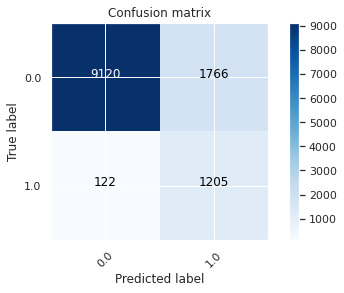

In [41]:
# Confusion Matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [42]:
# Metrics function to evaluate recall, precision and f1score

from pyspark.mllib.evaluation import MulticlassMetrics

results = predictions.select(['prediction', 'label'])
predictionAndLabels=results.rdd
metrics = MulticlassMetrics(predictionAndLabels)

cm=metrics.confusionMatrix().toArray()
accuracy=(cm[0][0]+cm[1][1])/cm.sum()
precision=(cm[1][1])/(cm[1][1]+cm[0][1])
recall=(cm[1][1])/(cm[1][1]+cm[1][0])
f1score =((2*precision*recall )/ (precision + recall))


# Calculating test area under roc
evaluator = BinaryClassificationEvaluator()
auc=evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})

metrics_dict = {'model': model, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1score': f1score, 'auc': auc}
metrics_list.append(metrics_dict)
metrics_dict

{'model': LinearSVC_5830fbc0e036,
 'accuracy': 0.8454106280193237,
 'precision': 0.4055873443285089,
 'recall': 0.9080633006782216,
 'f1score': 0.560725919032108,
 'auc': 0.9354247575856718}

In [43]:
svModel.coefficients

DenseVector([-0.0022, 1.2395, -0.0553, -0.0931, -0.006, -1.4412, 0.4257, 0.0365, 0.58, -0.2817, -0.1154, -0.1562, -0.0986, -0.1108, -0.0676, 0.0157, -0.0665, -0.0563, -0.0384, -0.0206, -0.0046, 0.0396, -0.0395, 0.0009, -0.0035, 0.0397, 0.0297, -0.0615, -0.0134, -0.0339, 0.0239, -0.0661, -0.0597, -0.0245, -0.0694, -0.0035, 0.0169, 0.0804, -0.3332, 0.0347, 0.1753, -0.0684, -0.1135, 0.0155, 0.0339, 0.0041, 0.1413, 0.0069, 0.0227, 0.0413, 0.0531, -0.0679, -0.1589])

In [44]:
# Model Weights
from itertools import chain
attrs = sorted(
                  (attr["idx"], attr["name"])
                  for attr in (
                      chain(*df_pipeline.schema["vectorized_features"].metadata["ml_attr"]["attrs"].values())
                  )
              ) 

input_features = pd.DataFrame(attrs, columns=["idx", "Features"])

# Weights
feature_imp = pd.DataFrame(svModel.coefficients.values.tolist(),columns =['Weights'])
pd.concat([input_features, feature_imp], axis=1).sort_values(by=['Weights'], ascending=False).drop(columns=["idx"], axis=1).head(10)

,Features,Weights
1,duration,1.239538
8,euribor3m,0.579999
6,cons_price_idx,0.425688
40,month_encoded_aug,0.175282
46,month_encoded_mar,0.141259
37,contact_encoded_cellular,0.080372
50,day_of_week_encoded_tue,0.053066
49,day_of_week_encoded_wed,0.041348
25,loan_encoded_no,0.039707
21,default_encoded_no,0.039575


## Decision Tree Model

In [45]:
# Importing package for Decision Tree Model
from pyspark.ml.classification import DecisionTreeClassifier

model = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', weightCol="weight")
# model = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 5, impurity="gini", weightCol="weight")

dtModel = model.fit(train)
predictions = dtModel.transform(test)
predictions.select( 'label', 'rawPrediction', 'prediction', 'probability').show(5)

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  0.0|[7715.14304476370...|       0.0|[0.98694136055648...|
|  0.0|[673.356408011384...|       0.0|[0.63821891709968...|
|  0.0|[7715.14304476370...|       0.0|[0.98694136055648...|
|  0.0|[673.356408011384...|       0.0|[0.63821891709968...|
|  0.0|[673.356408011384...|       0.0|[0.63821891709968...|
+-----+--------------------+----------+--------------------+
only showing top 5 rows



Confusion matrix, without normalization
[[9189 1697]
 [ 121 1206]]


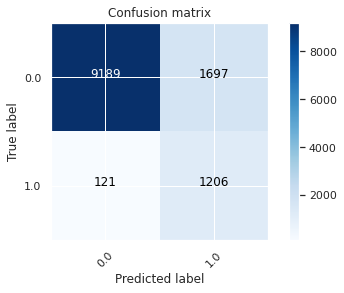

In [46]:
# Confusion Matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [47]:
# Metrics function to evaluate recall, precision and f1score

from pyspark.mllib.evaluation import MulticlassMetrics

results = predictions.select(['prediction', 'label'])
predictionAndLabels=results.rdd
metrics = MulticlassMetrics(predictionAndLabels)

cm=metrics.confusionMatrix().toArray()
accuracy=(cm[0][0]+cm[1][1])/cm.sum()
precision=(cm[1][1])/(cm[1][1]+cm[0][1])
recall=(cm[1][1])/(cm[1][1]+cm[1][0])
f1score =((2*precision*recall )/ (precision + recall))


# Calculating test area under roc
evaluator = BinaryClassificationEvaluator()
auc=evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})

metrics_dict = {'model': model, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1score': f1score, 'auc': auc}
metrics_list.append(metrics_dict)
metrics_dict

{'model': DecisionTreeClassifier_e2933ff7b468,
 'accuracy': 0.8511422254974208,
 'precision': 0.41543231140199793,
 'recall': 0.908816880180859,
 'f1score': 0.5702127659574469,
 'auc': 0.8785080454960992}

In [48]:
dtModel.featureImportances

SparseVector(53, {1: 0.574, 2: 0.0001, 3: 0.0114, 4: 0.0001, 6: 0.0011, 7: 0.0454, 8: 0.0184, 9: 0.3372, 44: 0.0123})

In [49]:
# Feature Importance

from itertools import chain
attrs = sorted(
                  (attr["idx"], attr["name"])
                  for attr in (
                      chain(*df_pipeline.schema["vectorized_features"].metadata["ml_attr"]["attrs"].values())
                  )
              ) 

mapped = [
            [name, dtModel.featureImportances[idx]]
            for idx, name in attrs
            if dtModel.featureImportances[idx]
       ]
 
# Top Features
pd.DataFrame(mapped, columns = ['Feature', 'Importance']).sort_values(by=['Importance'], ascending=False).head(10)

,Feature,Importance
0,duration,0.573994
7,nr_employed,0.337176
5,cons_conf_idx,0.045359
6,euribor3m,0.018390
8,month_encoded_oct,0.012342
2,pdays,0.011379
4,cons_price_idx,0.001121
3,previous,0.000120
1,campaign,0.000120


## Random Forest Model

In [50]:
# Importing package for RF MODEL
from pyspark.ml.classification import RandomForestClassifier

model = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', weightCol='weight')
# model = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 5, numTrees=50, weightCol='weight')

rfModel = model.fit(train)
predictions = rfModel.transform(test)
predictions.select( 'label', 'rawPrediction', 'prediction', 'probability').show(5)

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  0.0|[13.5083060160837...|       0.0|[0.67541530080418...|
|  0.0|[10.7677719907926...|       0.0|[0.53838859953963...|
|  0.0|[13.0334040341431...|       0.0|[0.65167020170715...|
|  0.0|[10.8661628562083...|       0.0|[0.54330814281041...|
|  0.0|[8.58946213224159...|       1.0|[0.42947310661207...|
+-----+--------------------+----------+--------------------+
only showing top 5 rows



Confusion matrix, without normalization
[[9146 1740]
 [ 256 1071]]


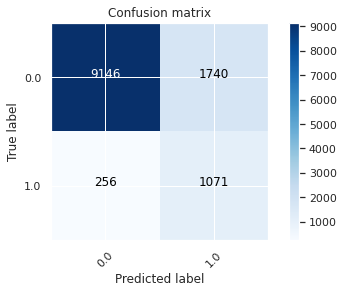

In [51]:
# Confusion Matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [52]:
# Metrics function to evaluate recall, precision and f1score

from pyspark.mllib.evaluation import MulticlassMetrics

results = predictions.select(['prediction', 'label'])
predictionAndLabels=results.rdd
metrics = MulticlassMetrics(predictionAndLabels)

cm=metrics.confusionMatrix().toArray()
accuracy=(cm[0][0]+cm[1][1])/cm.sum()
precision=(cm[1][1])/(cm[1][1]+cm[0][1])
recall=(cm[1][1])/(cm[1][1]+cm[1][0])
f1score =((2*precision*recall )/ (precision + recall))


# Calculating test area under roc
evaluator = BinaryClassificationEvaluator()
auc=evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})

metrics_dict = {'model': model, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1score': f1score, 'auc': auc}
metrics_list.append(metrics_dict)
metrics_dict

{'model': RandomForestClassifier_affe14a68409,
 'accuracy': 0.8365675919102595,
 'precision': 0.3810032017075774,
 'recall': 0.8070836473247928,
 'f1score': 0.5176413726437893,
 'auc': 0.9126415765165627}

In [53]:
rfModel.featureImportances

SparseVector(53, {0: 0.0048, 1: 0.2801, 2: 0.0013, 3: 0.0367, 4: 0.0138, 5: 0.1165, 6: 0.0399, 7: 0.0193, 8: 0.1315, 9: 0.22, 10: 0.0, 11: 0.0041, 12: 0.0, 14: 0.0005, 15: 0.0001, 16: 0.0, 17: 0.0002, 18: 0.0, 19: 0.0, 20: 0.0001, 21: 0.0026, 22: 0.0018, 23: 0.0001, 26: 0.0003, 28: 0.0011, 29: 0.0001, 30: 0.0005, 32: 0.0002, 33: 0.0, 34: 0.0006, 35: 0.0001, 37: 0.0303, 38: 0.0268, 39: 0.0004, 40: 0.0003, 42: 0.0005, 43: 0.0094, 44: 0.0091, 45: 0.0014, 46: 0.0073, 48: 0.0005, 49: 0.0001, 50: 0.0001, 51: 0.0342, 52: 0.0032})

In [54]:
# Feature Importance

from itertools import chain
attrs = sorted(
                  (attr["idx"], attr["name"])
                  for attr in (
                      chain(*df_pipeline.schema["vectorized_features"].metadata["ml_attr"]["attrs"].values())
                  )
              ) 

mapped = [
            [name, rfModel.featureImportances[idx]]
            for idx, name in attrs
            if rfModel.featureImportances[idx]
       ]
 
# Top Features
pd.DataFrame(mapped, columns = ['Feature', 'Importance']).sort_values(by=['Importance'], ascending=False).head(10)

,Feature,Importance
1,duration,0.280093
9,nr_employed,0.220024
8,euribor3m,0.131527
5,emp_var_rate,0.116503
6,cons_price_idx,0.039885
3,pdays,0.036674
43,poutcome_encoded_nonexistent,0.034186
31,contact_encoded_cellular,0.030339
32,month_encoded_may,0.026836
7,cons_conf_idx,0.019318


## Gradient Boosting Model

In [55]:
# Importing package for GBTClassifier model
from pyspark.ml.classification import GBTClassifier

model = GBTClassifier(featuresCol = 'features', labelCol = 'label', weightCol="weight")
# model = GBTClassifier(featuresCol = 'features', labelCol = 'label', maxIter=10, weightCol="weight")

gbtModel = model.fit(train)
predictions = gbtModel.transform(test)
predictions.select( 'label', 'rawPrediction', 'prediction', 'probability').show(5)

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  0.0|[1.54150600027751...|       0.0|[0.95618654239317...|
|  0.0|[0.67889104194661...|       0.0|[0.79539899177199...|
|  0.0|[1.54150600027751...|       0.0|[0.95618654239317...|
|  0.0|[0.52878070916151...|       0.0|[0.74222425344585...|
|  0.0|[-0.4853872888681...|       1.0|[0.27472613936155...|
+-----+--------------------+----------+--------------------+
only showing top 5 rows



Confusion matrix, without normalization
[[9289 1597]
 [ 114 1213]]


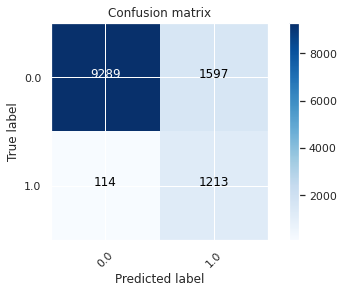

In [56]:
# Confusion Matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [57]:
# Metrics function to evaluate recall, precision and f1score

from pyspark.mllib.evaluation import MulticlassMetrics

results = predictions.select(['prediction', 'label'])
predictionAndLabels=results.rdd
metrics = MulticlassMetrics(predictionAndLabels)

cm=metrics.confusionMatrix().toArray()
accuracy=(cm[0][0]+cm[1][1])/cm.sum()
precision=(cm[1][1])/(cm[1][1]+cm[0][1])
recall=(cm[1][1])/(cm[1][1]+cm[1][0])
f1score =((2*precision*recall )/ (precision + recall))


# Calculating test area under roc
evaluator = BinaryClassificationEvaluator()
auc=evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})

metrics_dict = {'model': model, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1score': f1score, 'auc': auc}
metrics_list.append(metrics_dict)
metrics_dict

{'model': GBTClassifier_90ba6940d533,
 'accuracy': 0.8599033816425121,
 'precision': 0.4316725978647687,
 'recall': 0.9140919366993218,
 'f1score': 0.5864152767706068,
 'auc': 0.9444730419151083}

In [58]:
gbtModel.featureImportances

SparseVector(53, {0: 0.0317, 1: 0.4186, 2: 0.0183, 3: 0.0177, 4: 0.0036, 5: 0.0343, 6: 0.0192, 7: 0.0402, 8: 0.1043, 9: 0.1638, 10: 0.0012, 11: 0.0094, 12: 0.0006, 13: 0.0022, 14: 0.0005, 15: 0.0005, 16: 0.0017, 17: 0.0027, 18: 0.0026, 19: 0.0011, 20: 0.0007, 21: 0.0017, 22: 0.0056, 23: 0.0004, 24: 0.0007, 27: 0.0017, 28: 0.0015, 29: 0.0018, 30: 0.0097, 31: 0.0007, 32: 0.0008, 33: 0.001, 34: 0.0036, 35: 0.0004, 37: 0.0078, 38: 0.0131, 39: 0.0006, 40: 0.0001, 41: 0.0005, 42: 0.0015, 43: 0.0067, 44: 0.0297, 46: 0.0061, 47: 0.0034, 48: 0.0073, 49: 0.0043, 50: 0.0032, 51: 0.0002, 52: 0.0115})

In [59]:
# Feature Importance

from itertools import chain
attrs = sorted(
                  (attr["idx"], attr["name"])
                  for attr in (
                      chain(*df_pipeline.schema["vectorized_features"].metadata["ml_attr"]["attrs"].values())
                  )
              ) 

mapped = [
            [name, gbtModel.featureImportances[idx]]
            for idx, name in attrs
            if rfModel.featureImportances[idx]
         ]
 
# Top Features
pd.DataFrame(mapped, columns = ['Feature', 'Importance']).sort_values(by=['Importance'], ascending=False).head(10)

,Feature,Importance
1,duration,0.418595
9,nr_employed,0.163776
8,euribor3m,0.104315
7,cons_conf_idx,0.040156
5,emp_var_rate,0.034292
0,age,0.031693
37,month_encoded_oct,0.029717
6,cons_price_idx,0.019217
2,campaign,0.018320
3,pdays,0.017716


# Comparison

In [60]:
pd.DataFrame.from_dict(metrics_list).set_index("model").style.highlight_max(color = 'yellow', axis = 0)

,accuracy,precision,recall,f1score,auc
model,,,,,
LogisticRegression_10146ae4e77f,0.859658,0.429043,0.881688,0.577208,0.936069
LinearSVC_5830fbc0e036,0.845411,0.405587,0.908063,0.560726,0.935425
DecisionTreeClassifier_e2933ff7b468,0.851142,0.415432,0.908817,0.570213,0.878508
RandomForestClassifier_affe14a68409,0.836568,0.381003,0.807084,0.517641,0.912642
GBTClassifier_90ba6940d533,0.859903,0.431673,0.914092,0.586415,0.944473


# Best Model

## Cross Validation and Parameter Tuning

In [61]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction',labelCol='label', metricName='fMeasureByLabel', metricLabel=1, beta=1.0) 
# print('F1 score', evaluator.evaluate(predictions))

In [62]:
%%time
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
# https://www.sparkitecture.io/machine-learning/classification/gradient-boosted-trees

model = GBTClassifier(featuresCol = 'features', labelCol = 'label', weightCol="weight")

# Create ParamGrid for Cross Validation
gbparamGrid = (ParamGridBuilder()
             .addGrid(model.maxDepth, [2, 5])
             .addGrid(model.maxBins, [10, 20])
             .addGrid(model.maxIter, [5, 10])
             .build())

cv = CrossValidator(estimator=model, estimatorParamMaps=gbparamGrid, 
                    evaluator=evaluator, numFolds=3)

cvModel = cv.fit(train)

CPU times: user 2.72 s, sys: 430 ms, total: 3.15 s
Wall time: 2min 43s


## Best Model Performance

In [63]:
best_model=cvModel.bestModel
best_model

GBTClassificationModel: uid = GBTClassifier_0000cc5bae4d, numTrees=10, numClasses=2, numFeatures=53

In [64]:
## Evaluate Best Model
predictions = cvModel.transform(test)
print('Best Model Test F1', evaluator.evaluate(predictions))

Best Model Test F1 0.5728268468888371


In [65]:
# Metrics function to evaluate recall, precision and f1score

from pyspark.mllib.evaluation import MulticlassMetrics

results = predictions.select(['prediction', 'label'])
predictionAndLabels=results.rdd
metrics = MulticlassMetrics(predictionAndLabels)

cm=metrics.confusionMatrix().toArray()
accuracy=(cm[0][0]+cm[1][1])/cm.sum()
precision=(cm[1][1])/(cm[1][1]+cm[0][1])
recall=(cm[1][1])/(cm[1][1]+cm[1][0])
f1score =((2*precision*recall )/ (precision + recall))


# Calculating test area under roc
evaluator = BinaryClassificationEvaluator()
auc=evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})

metrics_dict = {'model': best_model.uid, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1score': f1score, 'auc': auc}
metrics_list.append(metrics_dict)
metrics_dict

{'model': 'GBTClassifier_0000cc5bae4d',
 'accuracy': 0.8499140260378285,
 'precision': 0.41464237516869096,
 'recall': 0.9261492087415222,
 'f1score': 0.5728268468888371,
 'auc': 0.9425893008324536}

## Best Model Parameters

In [66]:
best_model=cvModel.bestModel
best_model.explainParams().split("\n")

['cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)',
 'checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)',
 "featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of fe

## Best Model Feature Weights

In [67]:
# Feature Importance

from itertools import chain
attrs = sorted(
                  (attr["idx"], attr["name"])
                  for attr in (
                      chain(*df_pipeline.schema["vectorized_features"].metadata["ml_attr"]["attrs"].values())
                  )
              ) 

mapped = [
            [name, best_model.featureImportances[idx]]
            for idx, name in attrs
            if best_model.featureImportances[idx]
         ]
 
# Top Features
pd.DataFrame(mapped, columns = ['Feature', 'Importance']).sort_values(by=['Importance'], ascending=False).head(10)

,Feature,Importance
1,duration,0.449452
9,nr_employed,0.222170
8,euribor3m,0.078273
7,cons_conf_idx,0.037278
25,month_encoded_oct,0.035836
0,age,0.026460
5,emp_var_rate,0.020804
6,cons_price_idx,0.017382
11,job_encoded_blue-collar,0.014950
2,campaign,0.013952


# Save Models

In [68]:
lrModel.write().overwrite().save("/content/lrModel.pkl")
svModel.write().overwrite().save("/content/svModel.pkl")
dtModel.write().overwrite().save("/content/dtModel.pkl")
rfModel.write().overwrite().save("/content/rfModel.pkl")
gbtModel.write().overwrite().save("/content/gbtModel.pkl")
cvModel.write().overwrite().save("/content/best_Model.pkl")

# # Example: For loading the models
# pipelineModel = gbtModel.load("/content/model.pkl")
# predictions = pipelineModel.transform(test)
# predictions.select( 'label', 'rawPrediction', 'prediction', 'probability').show(10)